In [1]:
!pip install Flask-ngrok
!pip install Flask pyngrok

In [2]:
!pip install nltk 
!pip install spacy

In [3]:
!pip install wordcloud

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
import csv
from urllib.request import urlopen
from urllib.request import urlopen
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import string
import spacy
import re
import nltk
import csv
nltk.download('punkt')
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from flask import Flask, request, jsonify, render_template_string
from flask_ngrok import run_with_ngrok

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Open the CSV file in write mode and initialize the CSV writer
with open("Wuzzuf.csv", "w", newline='', encoding="utf-8") as file:
    writer = csv.writer(file)
    header = ["job_title", "company_name", "job_type", "location", "experience_years", "skills"]
    writer.writerow(header)

    base_url = 'https://wuzzuf.net/a/IT-Software-Development-Jobs-in-Egypt?ref=browse-jobs&start='

    for page in range(1, 60):
        url_wuzzuf = base_url + str(page)
        client = urlopen(url_wuzzuf)
        html = client.read()
        client.close()
        soup = bs(html, "html.parser")
        containers = soup.find_all("div", {"class": "css-1gatmva e1v1l3u10"})

        for x in containers:
            try:
                job_title = x.find("h2", {"class": "css-m604qf"}).text.strip()
                company_name = x.find("a", {"class": "css-17s97q8"}).text.strip()
                job_type = x.find("span", {"class": "css-o1vzmt eoyjyou0"}).text.strip()
                location = x.find("span", {"class": "css-5wys0k"}).text.strip().split(',')[0].strip()
                experience_years = ""
                experience_years_container = x.find_all("span")

                for span in experience_years_container:
                    if "Yrs of Exp" in span.text:
                        experience_years = span.text.replace(" Yrs of Exp", "").strip()
                        break

                skills_container = x.find_all("a", {"class": ["css-o171kl", "css-5x9pm1"]})

                # Option 1: Skills enclosed in square brackets
                skills = [f"[{skill.text.strip(' ·')}]" for skill in skills_container]
                skills = ' '.join(skills)  # Join with a space

                # Option 2: Skills on a new line
                # skills = [skill.text.strip(" ·") for skill in skills_container]
                # skills = '\n'.join(skills)  # Join with newline

                writer.writerow([job_title, company_name, job_type, location, experience_years, skills])

            except Exception as e:
                print(f"Error processing job: {e}")
                continue


In [6]:
 # Set up Ngrok tunnel
# Load the CSV file into a pandas DataFrame
df = pd.read_csv("Wuzzuf.csv")
# Display the first few rows of the DataFrame
pd.set_option('display.max_colwidth', None)
df.shape

(1180, 6)

In [7]:
print(df.duplicated().sum())
print(df.isnull().sum())
pd.set_option('display.max_colwidth', None)
df.head()

0
job_title            0
company_name         0
job_type             0
location             0
experience_years    27
skills               0
dtype: int64


,job_title,company_name,job_type,location,experience_years,skills
0,Warehouse Manager,Audio Technology -,On-site,Heliopolis,· 10 - 15,[Warehouse Manager] [Manager] [Logistics/Supply Chain] [Operations/Management] [Supply Chain] [Warehouse Management] [Warehouse] [Warehousing] [Logistics] [Operations]
1,Senior NET Developer,Confidential -,On-site,Sheikh Zayed,· 3 - 7,[Senior NET Developer] [Experienced] [IT/Software Development] [Engineering - Telecom/Technology] [DevOps] [Software Development] [ASP.Net Web API] [Web Development] [developer] [senior] [Software] [software developer]
2,Google Cloud Engineer,Cloud11 -,Hybrid,Cairo,· 1 - 3,[Google Cloud Engineer] [Experienced] [IT/Software Development] [Engineering - Telecom/Technology] [AWS] [API] [Cloud Computing] [Computer Science] [Google cloud] [Information Technology (IT)] [Python] [Azure]
3,Senior Google workspace Engineer,Cloud11 -,Hybrid,Cairo,· 2 - 4,[Senior Google workspace Engineer] [Experienced] [IT/Software Development] [Engineering - Telecom/Technology] [Engineering - Mechanical/Electrical] [Communication] [Integration] [Security] [Troubleshooting] [Engineering] [Computer Science] [Automation]
4,IT Technical Support Representative,CLS Learning Solutions -,On-site,Nasr City,· 3 - 5,[IT Technical Support Representative] [Experienced] [Installation/Maintenance/Repair] [IT/Software Development] [Engineering - Telecom/Technology] [IT Technical Support] [IT Technical] [Information Technology (IT)] [Computer Science] [CISCO] [Information Security] [MCSA]


In [39]:
# Download NLTK stopwords
nltk.download('stopwords')
# Function to split skills and return a list of individual skills
def split_skills_list(row):
    skills_list = [skill.strip() for skill in row['skills'].split(',')]
    return skills_list
# Preprocessing function for text
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    #tokens =split_skills_list(text)
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
import nltk
nltk.download('wordnet')
# Check for missing values and handle them (if any)
df.fillna("", inplace=True)

# Preprocess the 'job_title' and 'skills' columns
df['job_title'] = df['job_title'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
df.head(10)

,job_title,company_name,job_type,location,experience_years,skills
0,warehouse manager,Audio Technology -,On-site,Heliopolis,· 10 - 15,[Warehouse Manager] [Manager] [Logistics/Supply Chain] [Operations/Management] [Supply Chain] [Warehouse Management] [Warehouse] [Warehousing] [Logistics] [Operations]
1,senior net developer,Confidential -,On-site,Sheikh Zayed,· 3 - 7,[Senior NET Developer] [Experienced] [IT/Software Development] [Engineering - Telecom/Technology] [DevOps] [Software Development] [ASP.Net Web API] [Web Development] [developer] [senior] [Software] [software developer]
2,google cloud engineer,Cloud11 -,Hybrid,Cairo,· 1 - 3,[Google Cloud Engineer] [Experienced] [IT/Software Development] [Engineering - Telecom/Technology] [AWS] [API] [Cloud Computing] [Computer Science] [Google cloud] [Information Technology (IT)] [Python] [Azure]
3,senior google workspace engineer,Cloud11 -,Hybrid,Cairo,· 2 - 4,[Senior Google workspace Engineer] [Experienced] [IT/Software Development] [Engineering - Telecom/Technology] [Engineering - Mechanical/Electrical] [Communication] [Integration] [Security] [Troubleshooting] [Engineering] [Computer Science] [Automation]
4,technical support representative,CLS Learning Solutions -,On-site,Nasr City,· 3 - 5,[IT Technical Support Representative] [Experienced] [Installation/Maintenance/Repair] [IT/Software Development] [Engineering - Telecom/Technology] [IT Technical Support] [IT Technical] [Information Technology (IT)] [Computer Science] [CISCO] [Information Security] [MCSA]
5,android developer kotlin,Confidential -,Hybrid,Cairo,· 4 - 6,[Android Developer (Kotlin)] [Experienced] [IT/Software Development] [Android SDK] [Android] [Information Technology (IT)] [Oracle] [JSON] [Kotlin] [Software Development] [Mobile Development] [Computer Science]
6,mobile application developer flutter,Al Ateeq Software -,On-site,Heliopolis,· 4 - 10,[Mobile Application Developer (Flutter )] [Experienced] [Creative/Design/Art] [IT/Software Development] [Engineering - Telecom/Technology] [Mobile Development] [Computer Science] [Development] [Information Technology (IT)] [OOP] [Software] [Software Development]
7,senior sale account manager,Datum International Data Systems -,On-site,Cairo,· 4+,[Senior Sales Account Manager] [Experienced] [Customer Service/Support] [IT/Software Development] [Sales/Retail] [Customer Service] [English] [excel] [Microsoft Office] [sales skills] [IT Sales]
8,technical support engineer,Datum International Data Systems -,On-site,Heliopolis,· 2 - 3,[Technical Support Engineer] [Experienced] [Installation/Maintenance/Repair] [IT/Software Development] [Engineering - Telecom/Technology] [Technical Support] [Information Technology (IT)] [Engineering] [Customer Care] [Maintenance] [Troubleshooting] [Hardware]
9,internal auditor,Jadara developments and investment -,On-site,Obour City,· 3 - 5,[Internal Auditor] [Experienced] [Accounting/Finance] [Accounting] [Auditing] [analytical] [Accounting Software] [auditor] [Internal auditor] [Procedures]


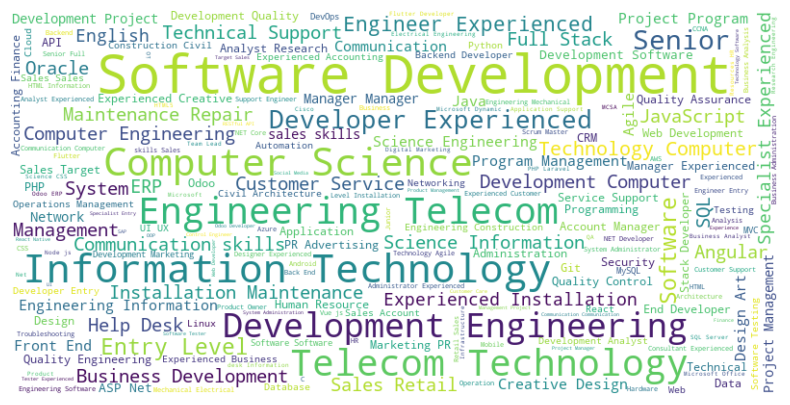

In [42]:

# Create a WordCloud for skills
skills_text = " ".join(skill for skill in df['skills'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(skills_text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
#Vectorize the 'skills' column using TF-IDF
vectorizer = TfidfVectorizer()
skills_tfidf = vectorizer.fit_transform(df['skills'])


In [44]:
#Calculate cosine similarity between your skills and job skills
cosine_sim = cosine_similarity(skills_tfidf, skills_tfidf)

#Define a function to recommend jobs based on skills
def recommend_jobs(user_skills, df, cosine_sim, top_n=5):
    user_skills = preprocess_text(user_skills)
    user_skills_tfidf = vectorizer.transform([user_skills])
    # Calculate cosine similarity between user skills and job skills
    user_cosine_sim = cosine_similarity(user_skills_tfidf, skills_tfidf).flatten()

    # Get indices of jobs sorted by similarity score
    job_indices = np.argsort(user_cosine_sim)[::-1]

    # Recommend top N jobs with percentage score
    recommended_jobs = df.iloc[job_indices[:top_n]][['job_title', 'company_name','skills']]

    # Add a new column for percentage score
    recommended_jobs['percentage_score'] = user_cosine_sim[job_indices[:top_n]] * 100

    return recommended_jobs

In [45]:
from sklearn.metrics.pairwise import euclidean_distances
#Calculate Euclidean distance between your skills and job skills
euclidean_sim = euclidean_distances(skills_tfidf, skills_tfidf)

#Define a function to recommend jobs based on Euclidean distance
def recommend_jobs_euclidean(user_skills, df, euclidean_sim, top_n=5):
   # Preprocess user skills
    user_skills = preprocess_text(user_skills)
    user_skills_tfidf = vectorizer.transform([user_skills])
    # Calculate Euclidean distance between user skills and job skills
    user_euclidean_sim = euclidean_distances(user_skills_tfidf, skills_tfidf).flatten()

    # Get indices of jobs sorted by smallest distance
    job_indices = np.argsort(user_euclidean_sim)

    # Recommend top N jobs with percentage score (inverse of distance)
    recommended_jobs = df.iloc[job_indices[:top_n]][['job_title', 'company_name', 'skills']]

    # Add a new column for percentage score
    recommended_jobs['percentage_score'] = (1 / (1 + user_euclidean_sim[job_indices[:top_n]])) * 100

    return recommended_jobs

In [46]:
from sklearn.metrics import jaccard_score
#Convert TF-IDF vectors to binary (presence/absence of skills)
skills_binary = (skills_tfidf > 0).astype(int)

#Define a function to manually calculate Jaccard similarity between two binary vectors
def jaccard_similarity(a, b):
    # Intersection: elements common between a and b
    intersection = np.sum(np.logical_and(a, b))
    # Union: all unique elements in a and b
    union = np.sum(np.logical_or(a, b))
    # Jaccard similarity = intersection / union
    if union == 0:
        return 0 # To avoid division by zero, return 0 if no common elements
    return intersection / union

#Define a function to recommend jobs based on Jaccard similarity
def recommend_jobs_jaccard(user_skills, df, skills_binary, top_n=5):
    
    # Preprocess user skills
    user_skills = preprocess_text(user_skills)
    user_skills_tfidf = vectorizer.transform([user_skills])
    # Convert user skills TF-IDF vector to binary
    user_skills_binary = (user_skills_tfidf > 0).astype(int).toarray()

    # Calculate Jaccard similarity between user skills and job skills
    user_jaccard_sim = np.array([jaccard_similarity(user_skills_binary[0], skills_binary[i].toarray()[0])
                              for i in range(skills_binary.shape[0])])

    # Get indices of jobs sorted by similarity score
    job_indices = np.argsort(user_jaccard_sim)[::-1]

    # Recommend top N jobs with percentage score
    recommended_jobs = df.iloc[job_indices[:top_n]][['job_title', 'company_name', 'skills']]

    # Add a new column for percentage score
    recommended_jobs['percentage_score'] = user_jaccard_sim[job_indices[:top_n]] * 100

    return recommended_jobs

In [47]:
from sklearn.metrics.pairwise import manhattan_distances
#Calculate Manhattan distance between your skills and job skills
manhattan_sim = manhattan_distances(skills_tfidf, skills_tfidf)

#Define a function to recommend jobs based on Manhattan distance
def recommend_jobs_manhattan(user_skills, df, manhattan_sim, top_n=5):
    # Preprocess user skills
    user_skills = preprocess_text(user_skills)
    user_skills_tfidf = vectorizer.transform([user_skills])
    # Calculate Manhattan distance between user skills and job skills
    user_manhattan_sim = manhattan_distances(user_skills_tfidf, skills_tfidf).flatten()

    # Get indices of jobs sorted by smallest distance
    job_indices = np.argsort(user_manhattan_sim)

    # Recommend top N jobs with percentage score (inverse of distance)
    recommended_jobs = df.iloc[job_indices[:top_n]][['job_title', 'company_name', 'skills']]

    # Add a new column for percentage score
    recommended_jobs['percentage_score'] = (1 / (1 + user_manhattan_sim[job_indices[:top_n]])) * 100

    return recommended_jobs

In [48]:
def jaccard_similarity(a, b):
    intersection = np.sum(np.logical_and(a, b))
    union = np.sum(np.logical_or(a, b))
    if union == 0:
        return 0
    return intersection / union

def recommend_jobs(user_skills, df, skills_tfidf, similarity_matrix, top_n=5, method='cosine'):
    user_skills = preprocess_text(user_skills)
    user_skills_tfidf = vectorizer.transform([user_skills])
    
    if method == 'cosine':
        user_sim = cosine_similarity(user_skills_tfidf, skills_tfidf).flatten()
    elif method == 'euclidean':
        user_sim = euclidean_distances(user_skills_tfidf, skills_tfidf).flatten()
        user_sim = (1 / (1 + user_sim)) * 100
    elif method == 'jaccard':
        user_skills_binary = (user_skills_tfidf > 0).astype(int).toarray()
        user_sim = np.array([jaccard_similarity(user_skills_binary[0], skills_binary[i].toarray()[0])
                             for i in range(skills_binary.shape[0])])
        user_sim *= 100
    elif method == 'manhattan':
        user_sim = manhattan_distances(user_skills_tfidf, skills_tfidf).flatten()
        user_sim = (1 / (1 + user_sim)) * 100
    else:
        raise ValueError("Unsupported method")

    job_indices = np.argsort(user_sim)[::-1]
    recommended_jobs = df.iloc[job_indices[:top_n]][['job_title', 'company_name', 'skills']]
    recommended_jobs['percentage_score'] = user_sim[job_indices[:top_n]]
    
    return recommended_jobs

In [49]:
user_skills = "Python Machine Learning Data Analysis"
recommended_jobs1 = recommend_jobs_euclidean(user_skills, df, cosine_sim, top_n=2)
recommended_jobs1

,job_title,company_name,skills,percentage_score
507,machine learning engineer,Afaqy -,[Machine Learning Engineer] [Experienced] [IT/Software Development] [Computer Science] [Machine Learning] [LLM] [Automation] [Python],57.814124
1163,machine learning engineer,Citylogix ME -,[Machine Learning Engineer] [Experienced] [IT/Software Development] [Engineering] [Deep Learning] [Computer Science] [Programming] [Python] [TensorFlow] [PyTorch] [Data visualization],53.411144


In [50]:
user_skills = "Python Machine Learning Data Analysis"
recommended_jobs2 = recommend_jobs_manhattan(user_skills, df, manhattan_sim, top_n=2)
recommended_jobs2

,job_title,company_name,skills,percentage_score
507,machine learning engineer,Afaqy -,[Machine Learning Engineer] [Experienced] [IT/Software Development] [Computer Science] [Machine Learning] [LLM] [Automation] [Python],31.824042
1163,machine learning engineer,Citylogix ME -,[Machine Learning Engineer] [Experienced] [IT/Software Development] [Engineering] [Deep Learning] [Computer Science] [Programming] [Python] [TensorFlow] [PyTorch] [Data visualization],24.547895


In [51]:
user_skills = "Python Machine Learning Data Analysis"
recommended_jobs3 = recommend_jobs_jaccard(user_skills, df, skills_binary, top_n=2)
recommended_jobs3

,job_title,company_name,skills,percentage_score
1071,ai data science machine learning instructor,CLS Learning Solutions -,[AI Data Science and Machine Learning Instructor] [Experienced] [Training/Instructor] [Machine Learning] [AI] [Deep Learning] [Data Science] [Python] [Natural Language Processing] [Neural Networks] [Training] [Teaching],22.222222
1163,machine learning engineer,Citylogix ME -,[Machine Learning Engineer] [Experienced] [IT/Software Development] [Engineering] [Deep Learning] [Computer Science] [Programming] [Python] [TensorFlow] [PyTorch] [Data visualization],22.222222


In [68]:
import pickle
with open('df.pkl', 'wb') as f: 
    pickle.dump(df, f)
with open('cosine_similarity.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)
with open('euclidean_similarity.pkl', 'wb') as f:
    pickle.dump(euclidean_sim, f)
with open('jaccard_similarity.pkl', 'wb') as f:
    pickle.dump(jaccard_similarity, f)
with open('manhattan_similarity.pkl', 'wb') as f:
    pickle.dump(manhattan_sim, f)
import pickle

try:
    # Load the TF-IDF matrix
    with open('skills_tfidf.pkl', 'rb') as f:
        skills_tfidf = pickle.load(f)

    # Load the TF-IDF vectorizer
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)

    print("TF-IDF matrix and vectorizer loaded successfully.")

except Exception as e:
    print(f"An error occurred while loading: {e}")

    

TF-IDF matrix and vectorizer loaded successfully.


In [69]:
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import pickle

# Initialize Flask app
app = Flask(__name__)

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load necessary data
def load_data():
    try:
        with open('df.pkl', 'rb') as f:
            df = pickle.load(f)
        with open('skills_tfidf.pkl', 'rb') as f:
            skills_tfidf = pickle.load(f)
        with open('tfidf_vectorizer.pkl', 'rb') as f:
            vectorizer = pickle.load(f)
        with open('euclidean_similarity.pkl', 'rb') as f:
            euclidean_sim = pickle.load(f)
        with open('jaccard_similarity.pkl', 'rb') as f:
            jaccard_similarity = pickle.load(f)
        with open('manhattan_similarity.pkl', 'rb') as f:
            manhattan_sim = pickle.load(f)
        return df, skills_tfidf, vectorizer, euclidean_sim, jaccard_similarity, manhattan_sim
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None, None, None

df, skills_tfidf, vectorizer, euclidean_sim, jaccard_similarity, manhattan_sim = load_data()

# Preprocessing function for text
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Define a function to manually calculate Jaccard similarity between two binary vectors
def jaccard_similarity(a, b):
    intersection = np.sum(np.logical_and(a, b))
    union = np.sum(np.logical_or(a, b))
    if union == 0:
        return 0
    return intersection / union

# Define a function to recommend jobs based on different similarity methods
def recommend_jobs(user_skills, df, skills_tfidf, vectorizer, method='cosine', top_n=5):
    user_skills = preprocess_text(user_skills)
    user_skills_tfidf = vectorizer.transform([user_skills])
    
    if method == 'cosine':
        user_sim = cosine_similarity(user_skills_tfidf, skills_tfidf).flatten()
    elif method == 'euclidean':
        user_sim = euclidean_distances(user_skills_tfidf, skills_tfidf).flatten()
        user_sim = (1 / (1 + user_sim)) * 100
    elif method == 'manhattan':
        user_sim = manhattan_distances(user_skills_tfidf, skills_tfidf).flatten()
        user_sim = (1 / (1 + user_sim)) * 100
    else:
        raise ValueError("Unsupported method")

    job_indices = np.argsort(user_sim)[::-1]
    recommended_jobs = df.iloc[job_indices[:top_n]][['job_title', 'company_name', 'skills']]
    recommended_jobs['percentage_score'] = user_sim[job_indices[:top_n]]
    
    return recommended_jobs

# Define the root route to render the main form
@app.route('/')
def index():
    
    return '''
    <html>
    <head>
    <style>
    body {
    font-family: Arial, sans-serif;
    background-color: #f4f4f4;
    margin: 0;
    padding: 0;
    }

                h1 {
                    text-align: center;
                    color: #333;
                }

                form {
                    max-width: 600px;
                    margin: 0 auto;
                    padding: 20px;
                    background: #fff;
                    border-radius: 8px;
                    box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
                }

                label {
                    font-size: 18px;
                    margin-bottom: 10px;
                    display: block;
                }

                input[type="text"], select {
                    width: 100%;
                    padding: 10px;
                    margin-bottom: 20px;
                    border: 1px solid #ddd;
                    border-radius: 4px;
                }

                input[type="submit"] {
                    background-color: #007bff;
                    color: #fff;
                    padding: 10px 20px;
                    border: none;
                    border-radius: 4px;
                    cursor: pointer;
                }

                input[type="submit"]:hover {
                    background-color: #0056b3;
                }
            </style>
        </head>
        <body>
            <h1>Job Recommendation System</h1>
            <form action="/recommend" method="post">
                <label for="skills">Enter your skills:</label><br>
                <input type="text" id="skills" name="skills"><br><br>

                <label for="similarity_method">Select similarity method:</label><br>
                <select id="similarity_method" name="similarity_method">
                    <option value="cosine">Cosine Similarity</option>
                    <option value="euclidean">Euclidean Similarity</option>
                    <option value="jaccard">Jaccard Similarity</option>
                    <option value="manhattan">Manhattan Similarity</option>
                </select><br><br>

                <input type="submit" value="Submit">
            </form>
        </body>
        </html>
    '''

# Define a route to handle job recommendations
@app.route('/recommend', methods=['POST'])
def recommend():
    user_skills = request.form['skills']
    method = request.form.get('method', 'cosine')  # Default to 'cosine' if not specified

    if df is None or skills_tfidf is None or vectorizer is None:
        return "Error: Data not loaded properly.", 500

    try:
        recommended_jobs = recommend_jobs(user_skills, df, skills_tfidf, vectorizer, method=method, top_n=5)
        
        # Render the results using HTML with inline CSS
        results = ""
        for index, row in recommended_jobs.iterrows():
            results += f"""
                <div class="job-card">
                    <h3>Job Title: {row['job_title']}</h3>
                    <p><strong>Company:</strong> {row['company_name']}</p>
                    <p><strong>Skills:</strong> {row['skills']}</p>
                    <p><strong>Match Percentage:</strong> {row['percentage_score']:.2f}%</p>
                </div>
                <br>
            """
        
        return f"""
            <html>
            <head>
                <style>
                    body {{
                        font-family: Arial, sans-serif;
                        background-color: #f4f4f4;
                        margin: 0;
                        padding: 0;
                    }}

                    h1 {{
                        text-align: center;
                        color: #333;
                    }}

                    .job-card {{
                        max-width: 600px;
                        margin: 0 auto;
                        padding: 20px;
                        background: #fff;
                        border-radius: 8px;
                        box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
                        margin-bottom: 20px;
                    }}

                    h3 {{
                        margin: 0;
                        color: #333;
                    }}

                    p {{
                        margin: 5px 0;
                        color: #555;
                    }}

                    strong {{
                        color: #333;
                    }}

                    a {{
                        text-decoration: none;
                        color: #007bff;
                    }}

                    a:hover {{
                        text-decoration: underline;
                    }}
                </style>
            </head>
            <body>
                <h1>Recommended Jobs</h1>
                {results}
                <a href="/">Go Back</a>
            </body>
            </html>
        """
    except Exception as e:
        print(f"Error in recommend route: {e}")
        return "Error processing recommendation.", 500

if __name__ == '__main__':
    app.run(host="0.0.0.0", port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.5:5000
Press CTRL+C to quit
192.168.1.5 - - [14/Sep/2024 12:05:21] "GET / HTTP/1.1" 200 -
192.168.1.5 - - [14/Sep/2024 12:05:33] "GET / HTTP/1.1" 200 -
C:\Users\cm\AppData\Local\Temp\ipykernel_13832\1577403019.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_jobs['percentage_score'] = cosine_similarities[top_indices] * 100
192.168.1.5 - - [14/Sep/2024 12:05:36] "POST /recommend HTTP/1.1" 200 -
